# I. Import libaries 

In [25]:
import pandas as pd
import numpy as np
import panel as pn
pn.extension('tabulator')

import hvplot.pandas
import holoviews as hv
import warnings
import geopandas as gpd
warnings.filterwarnings('ignore')

# II. Read data

In [26]:
# Load raw data
df_raw = pd.read_csv('https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv')

In [27]:
# Display raw data
df_raw.head(5)

country  year iso_code  population  gdp  cement_co2  \
0  Afghanistan  1850      AFG   3752993.0  NaN         NaN   
1  Afghanistan  1851      AFG   3767956.0  NaN         NaN   
2  Afghanistan  1852      AFG   3783940.0  NaN         NaN   
3  Afghanistan  1853      AFG   3800954.0  NaN         NaN   
4  Afghanistan  1854      AFG   3818038.0  NaN         NaN   

   cement_co2_per_capita  co2  co2_growth_abs  co2_growth_prct  ...  \
0                    NaN  NaN             NaN              NaN  ...   
1                    NaN  NaN             NaN              NaN  ...   
2                    NaN  NaN             NaN              NaN  ...   
3                    NaN  NaN             NaN              NaN  ...   
4                    NaN  NaN             NaN              NaN  ...   

   share_global_other_co2  share_of_temperature_change_from_ghg  \
0                     NaN                                   NaN   
1                     NaN                                 0.165   
2                     NaN                                 0.164   
3                     NaN                                 0.164   
4                     NaN                                 0.163   

   temperature_change_from_ch4  temperature_change_from_co2  \
0                          NaN                          NaN   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   temperature_change_from_ghg  temperature_change_from_n2o  total_ghg  \
0                          NaN                          NaN        NaN   
1                          0.0                          0.0        NaN   
2                          0.0                          0.0        NaN   
3                          0.0                          0.0        NaN   
4                          0.0                          0.0        NaN   

   total_ghg_excluding_lucf  trade_co2  trade_co2_share  
0                       NaN        NaN              NaN  
1                       NaN        NaN              NaN  
2                       NaN        NaN              NaN  
3                       NaN        NaN              NaN  
4                       NaN        NaN              NaN  

[5 rows x 79 columns]

In [28]:
# Cache data to improve performance
if 'data' not in pn.state.cache.keys():
    # Copy df_raw, including 'Longitude' and 'Latitude' columns
    pn.state.cache['data'] = df_raw.copy()
else:
    # If data is already cached, retrieve it
    df_raw = pn.state.cache['data']

# Assign the cached data to df
df = df_raw.copy()  # Make a copy of the cached data to work with as 'df'

# III. Data exploration and preparation

## 1. Data exploration

In [29]:
# Dimension
df.shape

(50598, 79)

In [30]:
# Column names
df.columns

Index(['country', 'year', 'iso_code', 'population', 'gdp', 'cement_co2',
       'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct',
       'co2_including_luc', 'co2_including_luc_growth_abs',
       'co2_including_luc_growth_prct', 'co2_including_luc_per_capita',
       'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy',
       'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2',
       'coal_co2_per_capita', 'consumption_co2', 'consumption_co2_per_capita',
       'consumption_co2_per_gdp', 'cumulative_cement_co2', 'cumulative_co2',
       'cumulative_co2_including_luc', 'cumulative_coal_co2',
       'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2',
       'cumulative_oil_co2', 'cumulative_other_co2', 'energy_per_capita',
       'energy_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'gas_co2',
       'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita',
       'land_use_change_co2', 'land_use_chang

In [31]:
# Keep only few columns for our dashboard
df = df[["country","year","iso_code","population","gdp","co2","co2_per_capita","co2_per_gdp","co2_per_unit_energy","coal_co2_per_capita","energy_per_capita","flaring_co2_per_capita","oil_co2_per_capita","other_co2_per_capita","temperature_change_from_co2"]]

In [32]:
# Type of columns
df.dtypes

country                         object
year                             int64
iso_code                        object
population                     float64
gdp                            float64
co2                            float64
co2_per_capita                 float64
co2_per_gdp                    float64
co2_per_unit_energy            float64
coal_co2_per_capita            float64
energy_per_capita              float64
flaring_co2_per_capita         float64
oil_co2_per_capita             float64
other_co2_per_capita           float64
temperature_change_from_co2    float64
dtype: object

## 2. Missing data

In [33]:
# Calculate the percentage of missing data
missing_data_percent = (df.isnull().sum() / len(df)) * 100

# Create a new DataFrame to store the results
missing_data_df = pd.DataFrame({'Column Name': missing_data_percent.index, 'Missing %': missing_data_percent.values})

# Print the results
print(missing_data_df)

                    Column Name  Missing %
0                       country   0.000000
1                          year   0.000000
2                      iso_code  16.712123
3                    population  20.929681
4                           gdp  71.216254
5                           co2  38.043006
6                co2_per_capita  46.806198
7                   co2_per_gdp  67.803075
8           co2_per_unit_energy  79.690897
9           coal_co2_per_capita  51.735246
10            energy_per_capita  79.603937
11       flaring_co2_per_capita  52.029724
12           oil_co2_per_capita  51.841970
13         other_co2_per_capita  95.284399
14  temperature_change_from_co2  17.538243


In [34]:
# Missing data come from early years, so I filter out data before 1900
df = df[df['year'] >= 1900]

In [35]:
df = df.fillna(0)

## 3. Duplicated values

In [36]:
df.duplicated().sum()

0

# IV. Building Plots

In [37]:
idf = df.interactive()

In [38]:
# Define Year Slider widgets
year_slider = pn.widgets.IntSlider(name='Year slider', 
                                   start=1900, 
                                   end=2020, 
                                   step=1, 
                                   value=2015
                                  )

In [39]:
year_slider

IntSlider(end=2020, name='Year slider', start=1900, value=2015)

In [40]:
# Define Country Choice widgets
multi_choice = pn.widgets.MultiChoice(name='Country', 
                                      value=[], 
                                      options=df["country"].unique().tolist() # All unique countries 
                                     )

In [41]:
multi_choice

MultiChoice(name='Country', options=['Afghanistan', ...])

## First plot: CO2 Measure

In [42]:
# Radio buttons for CO2 measures
yaxis_co2 = pn.widgets.RadioButtonGroup(
    name='Y axis', 
    options=['co2', 'co2_per_capita'],
    button_type='warning'
)

In [43]:
yaxis_co2

RadioButtonGroup(button_type='warning', name='Y axis', options=['co2', 'co2_per_capita'], value='co2')

In [44]:
# A list of continents from data
continents = ['World', 'Asia', 'Oceania', 'Europe', 'Africa', 'North America', 'South America', 'Antarctica']

In [45]:
# Create data pipeline
co2_pipeline = (
    idf[
        (idf.year <= year_slider) &
        (idf.country.isin(continents))
    ]
    .groupby(['country', 'year'])[yaxis_co2].mean()
    .to_frame()
    .reset_index()
    .sort_values(by='year')  
    .reset_index(drop=True)
)

In [46]:
co2_pipeline

In [47]:
# Connect data pipeline to plot
co2_plot = co2_pipeline.hvplot(x = 'year', 
                               by='country', 
                               y=yaxis_co2,
                               line_width=2, 
                               title="CO2 emission by continent")
co2_plot

## Second Plot: CO2 Sources by Country

In [48]:
# Create data pipeline

# Change data
if multi_choice.value == []:
    country_list = ["World"]
else:
    country_list= multi_choice.value

# List of columns of data
source = ['year','country','coal_co2_per_capita','flaring_co2_per_capita','oil_co2_per_capita', 'other_co2_per_capita']

# Data pipeline
source_pipeline = (
    idf[
        (idf.year == year_slider) &
        (idf.country.isin(country_list))
    ]
    .loc[:,source]  
    .reset_index(drop=True)
)

In [49]:
# Create a bar plot
source_plot = source_pipeline.hvplot.bar(
    x='country',
    y=['coal_co2_per_capita', 'flaring_co2_per_capita', 'oil_co2_per_capita', 'other_co2_per_capita'],
    stacked=False,
    title=f'Source break-down of CO2 per capital in {year_slider.value}',
    xlabel='Country',
    ylabel='CO2 source',
    legend='top_right',
    width=700,
    height=500,
    rot=90
)

source_plot

## Third Plot: CO2 and GDP

In [50]:
# Create data pipeline
co2_vs_gdp = (
    idf[
        (idf.year == year_slider) &
        (~ (idf.country.isin(continents))) & # Filter out Continents values
        (idf.gdp > 0)
    ]
    .groupby(['country', 'year', 'gdp'])['co2'].mean()
    .to_frame()
    .reset_index()
    .sort_values(by='year')  
    .reset_index(drop=True)
)

In [51]:
co2_vs_gdp

In [52]:
# Plot
gdp_scatterplot = co2_vs_gdp.hvplot(x='gdp', 
                                    y='co2',
                                    by='country', 
                                    size=80, 
                                    kind="scatter", 
                                    alpha=0.7,
                                    legend=False,  
                                    height=500, 
                                    width=500,
                                    title='GDP vs CO2 scatter plot',
                                    #trendline='ols'
                                   )
gdp_scatterplot

## Fourth Plot: Temperature change

In [53]:
# Check available datasets
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

`geopandas` has 3 datasets available `naturalearth_lowres` and `nybb` dataset consist of Polygon shapes whereas `naturalearth_cities` consist of Points shape. We'll try to load the naturalearth_lowres dataset which has information about each country’s shapes. It also holds information about the estimated country population and continent.

In [54]:
# Reading country level data from geopandas for country boundaries
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [55]:
# Merge data
df_map = df.merge(world, how="left", left_on=['country'], right_on=['name'])
# Display merged data
print("Type of DataFrame : ", type(df_map))
df_map.head()

Type of DataFrame :  <class 'pandas.core.frame.DataFrame'>


country  year iso_code  population  gdp  co2  co2_per_capita  \
0  Afghanistan  1900      AFG   4707744.0  0.0  0.0             0.0   
1  Afghanistan  1901      AFG   4751177.0  0.0  0.0             0.0   
2  Afghanistan  1902      AFG   4802500.0  0.0  0.0             0.0   
3  Afghanistan  1903      AFG   4861833.0  0.0  0.0             0.0   
4  Afghanistan  1904      AFG   4921891.0  0.0  0.0             0.0   

   co2_per_gdp  co2_per_unit_energy  coal_co2_per_capita  ...  \
0          0.0                  0.0                  0.0  ...   
1          0.0                  0.0                  0.0  ...   
2          0.0                  0.0                  0.0  ...   
3          0.0                  0.0                  0.0  ...   
4          0.0                  0.0                  0.0  ...   

   flaring_co2_per_capita  oil_co2_per_capita  other_co2_per_capita  \
0                     0.0                 0.0                   0.0   
1                     0.0                 0.0                   0.0   
2                     0.0                 0.0                   0.0   
3                     0.0                 0.0                   0.0   
4                     0.0                 0.0                   0.0   

   temperature_change_from_co2     pop_est  continent         name iso_a3  \
0                          0.0  38041754.0       Asia  Afghanistan    AFG   
1                          0.0  38041754.0       Asia  Afghanistan    AFG   
2                          0.0  38041754.0       Asia  Afghanistan    AFG   
3                          0.0  38041754.0       Asia  Afghanistan    AFG   
4                          0.0  38041754.0       Asia  Afghanistan    AFG   

  gdp_md_est                                           geometry  
0    19291.0  POLYGON ((66.51861 37.36278, 67.07578 37.35614...  
1    19291.0  POLYGON ((66.51861 37.36278, 67.07578 37.35614...  
2    19291.0  POLYGON ((66.51861 37.36278, 67.07578 37.35614...  
3    19291.0  POLYGON ((66.51861 37.36278, 67.07578 37.35614...  
4    19291.0  POLYGON ((66.51861 37.36278, 67.07578 37.35614...  

[5 rows x 21 columns]

In [56]:
# Create data pipeline
temperature = df_map.groupby(['country','geometry'])['temperature_change_from_co2'].sum().reset_index()

In [57]:
temperature.head(3)

country                                           geometry  \
0  Afghanistan  POLYGON ((66.51861 37.36278, 67.07578 37.35614...   
1      Albania  POLYGON ((21.02004 40.84273, 20.99999 40.58000...   
2      Algeria  POLYGON ((-8.68440 27.39574, -8.66512 27.58948...   

   temperature_change_from_co2  
0                        0.004  
1                        0.000  
2                        0.055

In [58]:

# Convert data into geopandas dataframe
gdf = gpd.GeoDataFrame(temperature, geometry='geometry')
print(type(gdf))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [59]:
map = gdf.hvplot.polygons(
    c="temperature_change_from_co2",
    cmap="YlOrRd",
    hover_fill_color="white",
    width=700,
    height=500,
    title="Cumulative Temperature Change from CO2 until 2020"
).opts(xaxis=False, yaxis=False)

map


:Polygons   [x,y]   (temperature_change_from_co2)

# V. Dashboard 

FastListTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [browser_info] BrowserInfo(dark_mode=False, device_pixel_ratio=0.800000011920929, language='en-US', timezone='America/Toronto', timezone_offset=240, webdriver=False)
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [6370905824] Row
        [0] Column
            [0] RadioButtonGroup(button_type='warning', name='Y axis', options=['co2', 'co2_per_capita'], value='co2')
            [1] ParamFunction(function, _pane=HoloViews, defer_load=False)
        [1] Column
            [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [6370914896] Row
        [0] Column
            [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
        [1] Column
            [0] HoloViews(Polygons, height=500, sizing_mode='fixed', width=700)
    [6046940368] Markdown(str)
    [6046933408] Markdown(str)
    [6369967600] PNG(str, sizing_mode='scale_both')
    [6369968032] Markdown(str)
    [5635644608] IntSlider(end=2020, name='Year slider', start=1900, value=2015)
    [5635014368] MultiChoice(name='Country', options=['Afghanistan', ...])
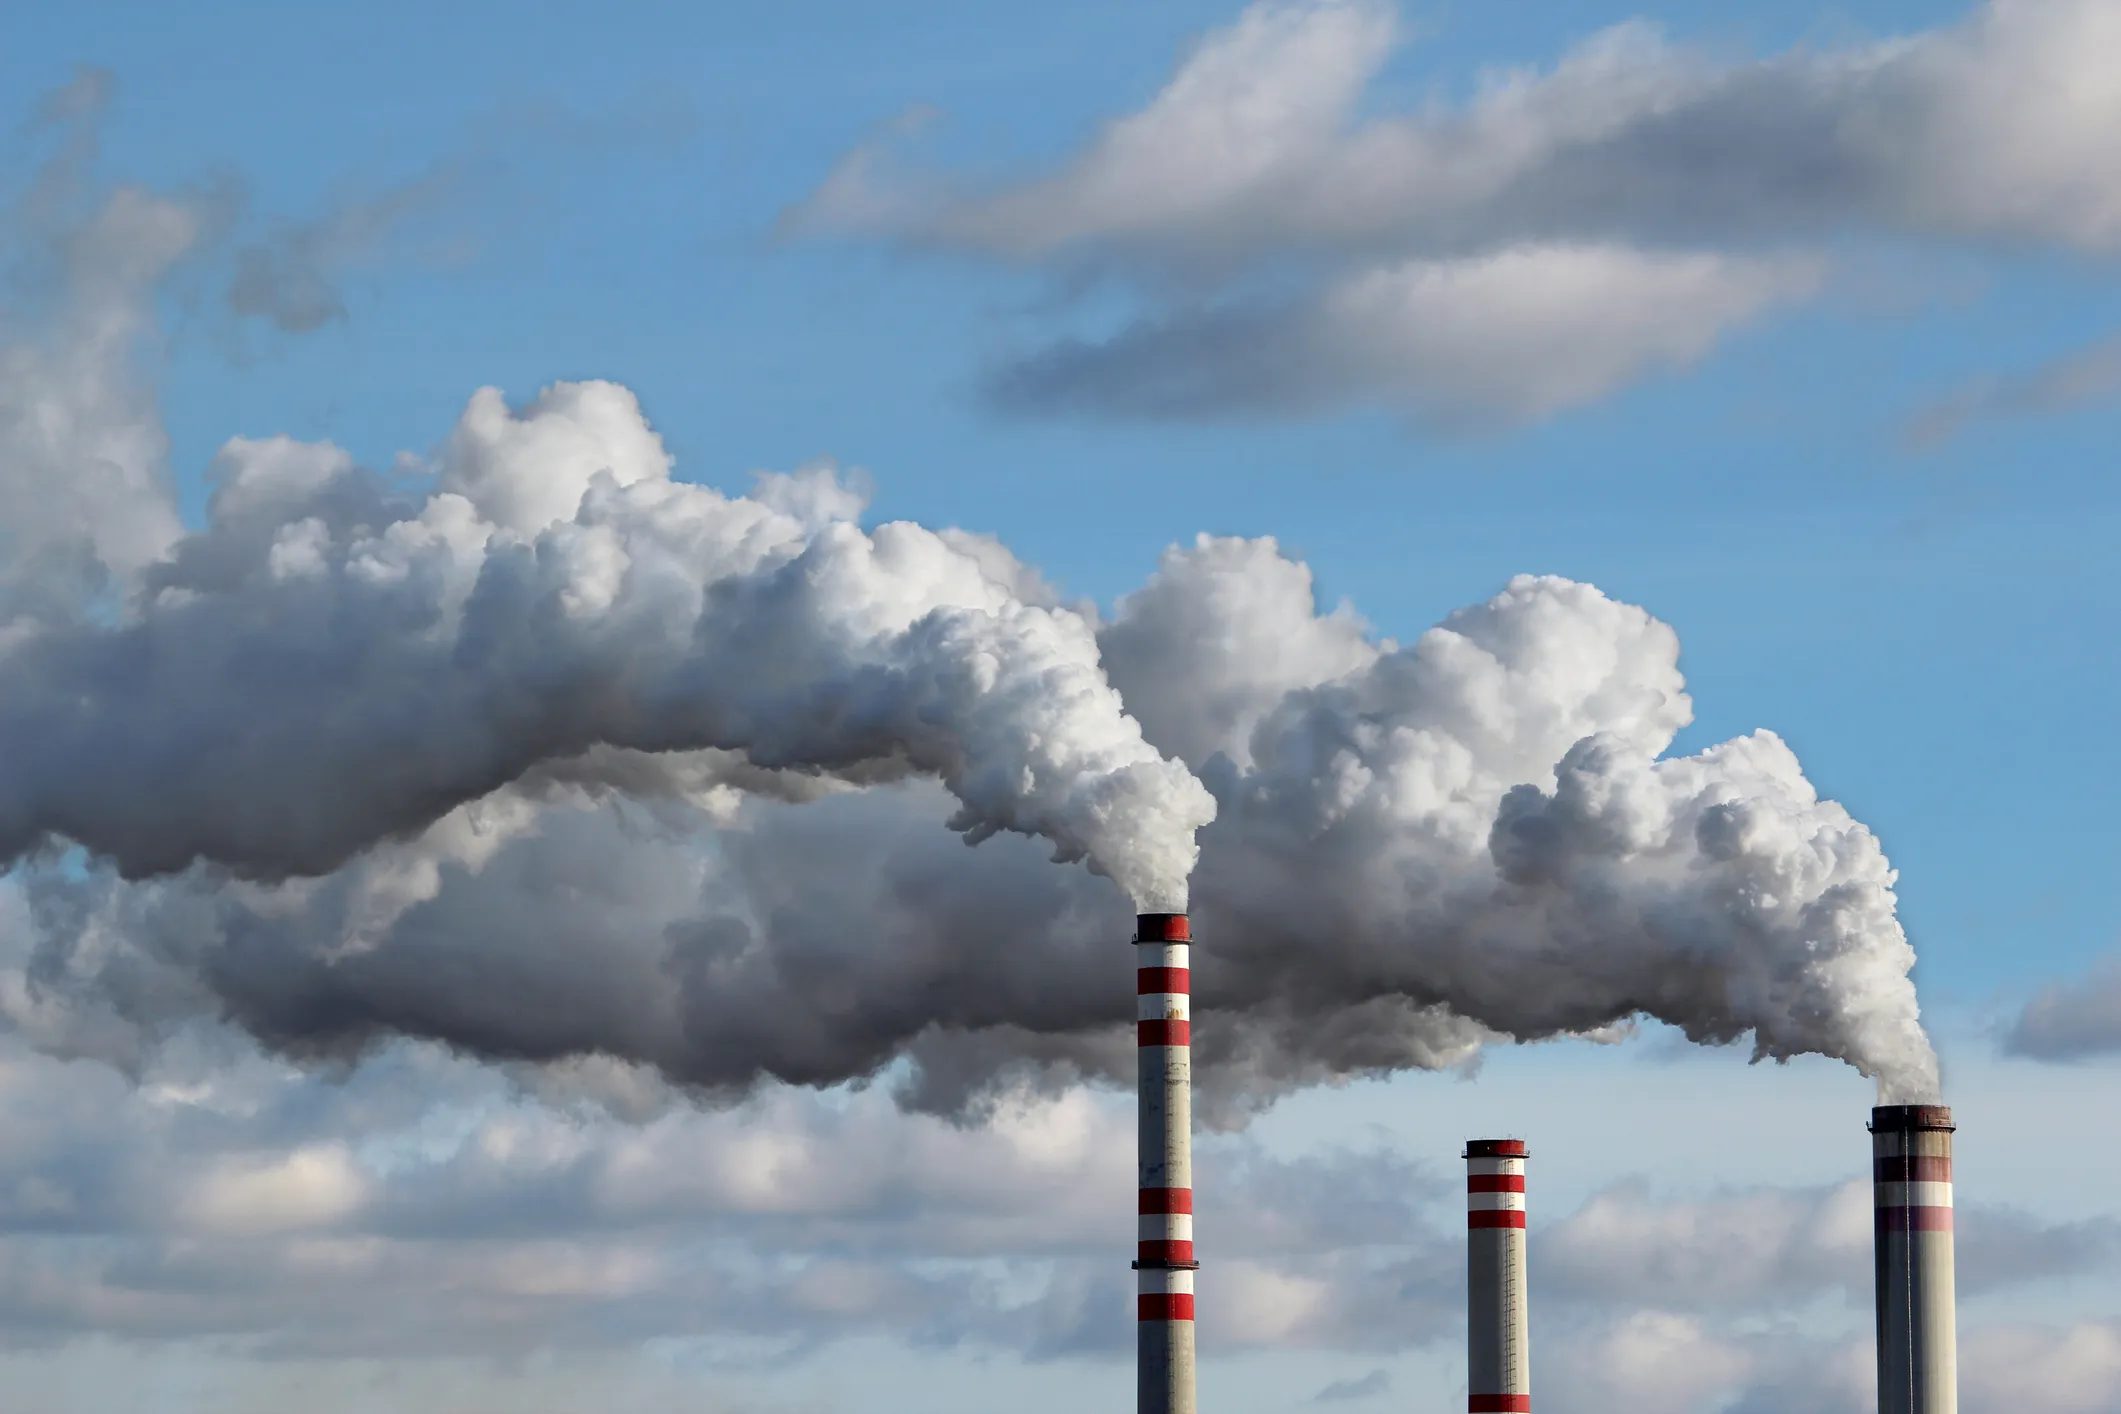

In [60]:
# Layout using Template
template = pn.template.FastListTemplate(
    title='World CO2 emission dashboard', 
    sidebar=[
        pn.pane.Markdown("# CO2 Emissions and Climate Change"), 
        pn.pane.Markdown("#### Carbon dioxide emissions are the primary driver of global climate change. It’s widely recognised that to avoid the worst impacts of climate change, the world needs to urgently reduce emissions. But, how this responsibility is shared between regions, countries, and individuals has been an endless point of contention in international discussions."), 
        pn.pane.PNG('co2.png', sizing_mode='scale_both'),
        pn.pane.Markdown("## Settings"),   
        year_slider,
        multi_choice
    ],
    main=[
        pn.Row(
            pn.Column(yaxis_co2, co2_plot.panel()),
            pn.Column(source_plot.panel())
        ), 
        pn.Row(
            pn.Column(gdp_scatterplot.panel()), 
            pn.Column(map)
        )
    ],
    accent_base_color="#88d8b0",
    header_background="#88d8b0",
)

# Display the template
template

In [61]:
template.show()

Launching server at http://localhost:49445
